In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scipy
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.stats.contingency_tables import cochrans_q

## Plotting usage concordance between two datasets

In [13]:
tra_df = pd.read_csv("TargSeq_TRA_all_df.csv")
trb_df = pd.read_csv("TargSeq_TRB_all_df.csv")
tra_df = tra_df[[x for x in tra_df.columns if x.startswith("TR")]]
trb_df = trb_df[[x for x in trb_df.columns if x.startswith("TR")]]
targseq_df = pd.concat([tra_df.mean().to_frame("targseq_mean"), trb_df.mean().to_frame("targseq_mean")])

sharon_df = pd.read_csv("sharon_allVDJRatios_table.csv")
sharon_df = sharon_df[[x for x in sharon_df.columns if x.startswith("TR")]]
sharon_df = sharon_df.mean().to_frame("sharon_mean")

tcr_df = pd.read_csv("DGN_TCR_df.csv")
tcr_df = tcr_df[[x for x in tcr_df.columns if x.startswith("TR")]]
dgn_df = tcr_df.mean().to_frame("dgn_mean")

liblau_cd4_df = pd.read_csv("liblau_usage_ratios_cd4_wide.csv")
liblau_cd4_df = liblau_cd4_df.mean().to_frame("liblau_mean")

merged_df = pd.merge(targseq_df, dgn_df, left_index=True, right_index=True, how="inner").fillna(0.0) # merge on TCR
merged_df = merged_df.reset_index().rename(columns={"index":"TCR"})
merged_df['segment'] = merged_df['TCR'].str.slice(start=0, stop=4)

In [14]:
merged_df

,TCR,targseq_mean,dgn_mean,segment
0,TRAJ10,1.980115e-02,0.028077,TRAJ
1,TRAJ11,1.350986e-02,0.011206,TRAJ
2,TRAJ12,8.878079e-03,0.016608,TRAJ
3,TRAJ13,1.971008e-02,0.023980,TRAJ
4,TRAJ14,7.277222e-07,0.000427,TRAJ
...,...,...,...,...
145,TRBV7-6,8.753847e-03,0.008516,TRBV
146,TRBV7-7,8.612302e-04,0.003532,TRBV
147,TRBV7-8,1.195349e-02,0.019763,TRBV
148,TRBV7-9,3.480592e-02,0.057201,TRBV


In [15]:
dataset1_name, dataset2_name = merged_df.columns[1], merged_df.columns[2]

In [16]:
#res = cochrans_q(merged_df[['targseq_mean', 'dgn_mean']].values)

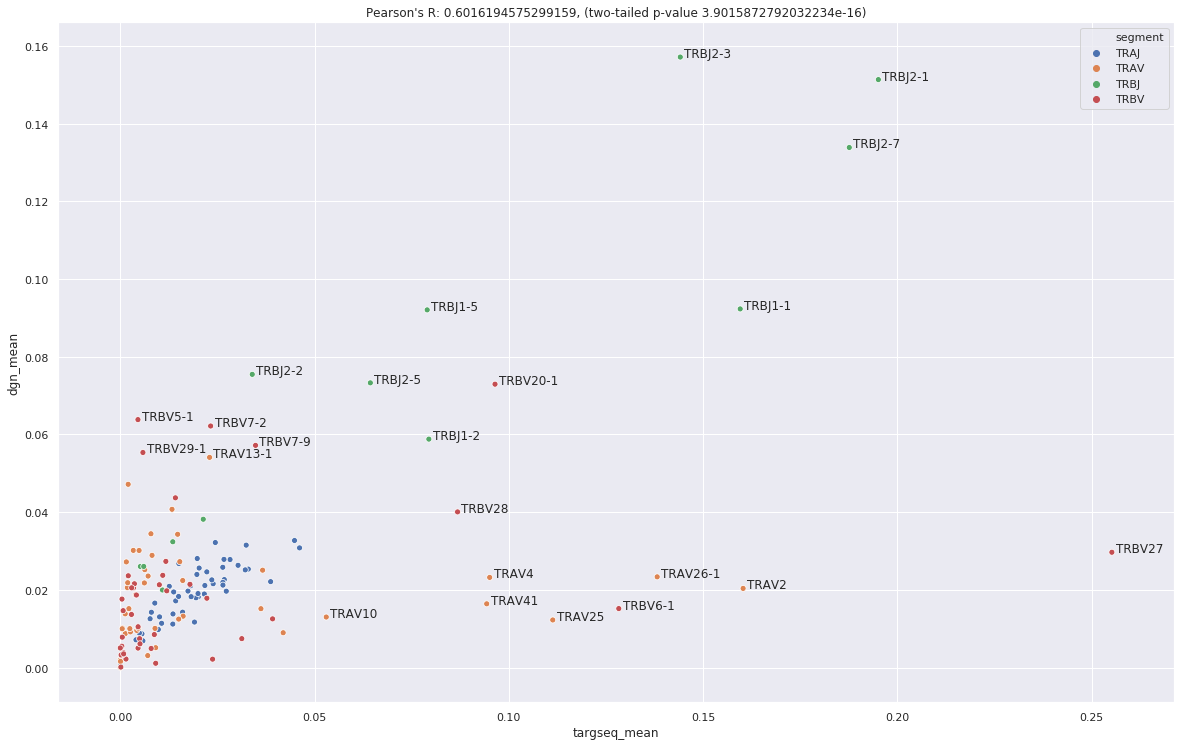

In [17]:
segment = "TRAV" # change this flag for different plots
plot_df = merged_df
#plot_df = merged_df[merged_df['segment']==segment] # comment this out to get all segments
r, p = scipy.stats.pearsonr(plot_df[dataset1_name], plot_df[dataset2_name])

sns.set()
fig, ax = plt.subplots(figsize=(20,60))
sns.scatterplot(x=dataset1_name, y=dataset2_name, hue="segment", data=plot_df)
#plt.xlim(-0.01, 0.16)
#plt.ylim(-0.01, 0.16)
ax.set_aspect('equal', 'box')
plt.xlabel(dataset1_name)
plt.ylabel(dataset2_name)
plt.title("Pearson's R: {}, (two-tailed p-value {})".format(r, p))

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        if point['x']>0.05 or point['y']>0.05:
        #if str(point['val']) in ['TRAV23/DV6', 'TRAV13-1', 'TRAV10-1', 'TRAV17']:
            ax.text(point['x']+.001, point['y'], str(point['val']))

label_point(plot_df[dataset1_name], plot_df[dataset2_name], plot_df.TCR, plt.gca())

## Plotting OLS Results

In [ ]:
# from sklearn import preprocessing

# def normalize_series(series):
#     min_max_scaler = preprocessing.MinMaxScaler()
#     x_scaled = min_max_scaler.fit_transform(series.reshape(-1,1))
#     return x_scaled

# # normalize OLS coefficients
# all_res_df["0301_coef_targseq"] = normalize_series(all_res_df["0301_coef_targseq"].values)
# all_res_df["0301_coef_dgn"] = normalize_series(all_res_df["0301_coef_dgn"].values)

In [24]:
group_602 = "pos" # all, pos, neg
dgn_res_df = pd.read_csv("dgn_res_df_0602{}.csv".format(group_602))
targseq_res_df = pd.read_csv("targseq_res_df_0602{}.csv".format(group_602))
all_res_df = pd.merge(dgn_res_df, targseq_res_df, on="TCR", how="outer", suffixes=('_dgn', '_targseq'))

In [25]:
# pd.set_option('display.max_rows', 200)
# all_res_df

/home/ashteng/36/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


(158.0, 0.0)

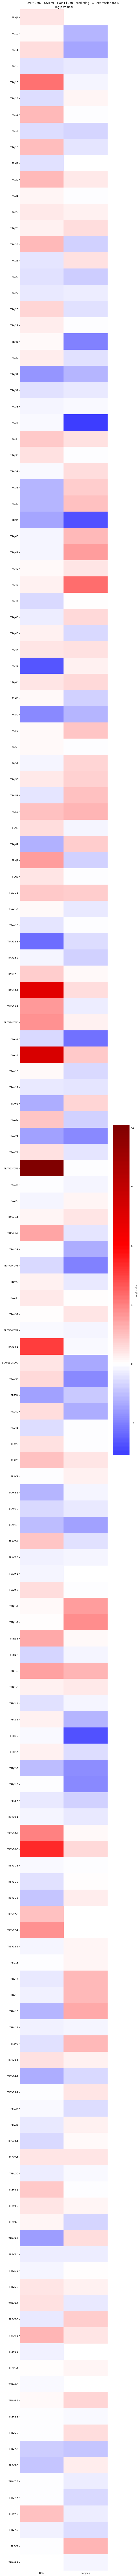

In [26]:
pvalue_mat = all_res_df[['pvalue_dgn', 'pvalue_targseq']].values
pvalue_mat = -np.log(pvalue_mat)
coefs_mat = all_res_df[['coef_dgn', 'coef_targseq']].values
tcr_columns = all_res_df['TCR'].values
#pvalue_mat = np.nan_to_num(pvalue_mat, nan=-0.1)
pvalue_mat.shape, coefs_mat.shape

-np.log(0.05/len(tcr_columns))

signed_pvalue_mat = pvalue_mat*np.where(coefs_mat>0, 1, -1)

fig, (ax1) = plt.subplots(sharex=False, sharey=True, figsize=((pvalue_mat.shape[1]//2+3)*2, (pvalue_mat.shape[0]//2)*2))
fig.tight_layout(pad=3.0)
ax1 = sns.heatmap(signed_pvalue_mat, cmap='seismic', center=0, cbar_kws={'label': "-log(pvalue)"}, ax=ax1)
fig.suptitle("[ONLY 0602 POSITIVE PEOPLE] 0301 predicting TCR expression (DGN)", y=1)
ax1.set_title("-log(p-values)")
ax1.set_yticklabels(tcr_columns, rotation=0)
ax1.set_xticklabels(['DGN', 'Targseq'])
bottom, top = ax1.get_ylim()
ax1.set_ylim(bottom + 0.5, top - 0.5)

Text(0.5, 1, 'Targseq coefs')

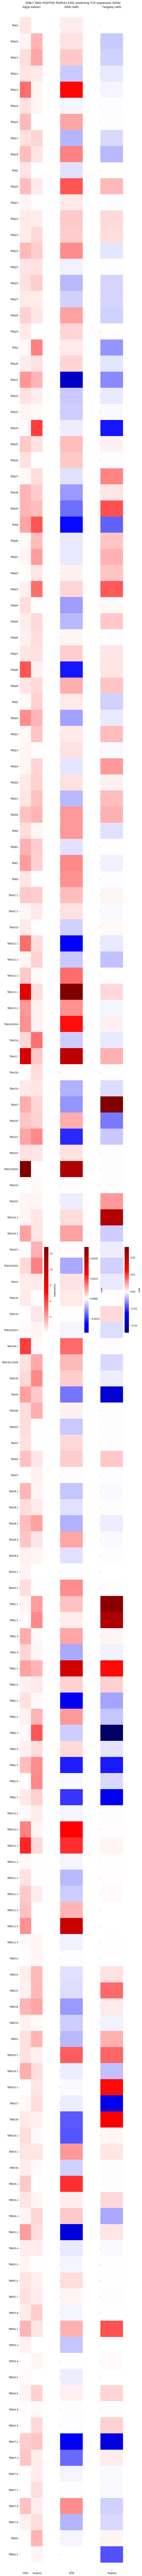

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, sharey=True, figsize=((pvalue_mat.shape[1]//2+3)*2, (pvalue_mat.shape[0]//2)*2))
fig.tight_layout(pad=3.0)
ax1 = sns.heatmap(pvalue_mat, cmap='seismic', center=0, cbar_kws={'label': "-log(pvalue)"}, ax=ax1)
ax2 = sns.heatmap(coefs_mat[:,None,0], cmap='seismic', center=0, cbar_kws={'label': "coef"}, ax=ax2)
ax3 = sns.heatmap(coefs_mat[:,None,1], cmap='seismic', center=0, cbar_kws={'label': "coef"}, ax=ax3)

fig.suptitle("[ONLY 0602 POSITIVE PEOPLE] 0301 predicting TCR expression (DGN)", y=1)

ax1.set_title("-log(p-values)")
ax1.set_yticklabels(tcr_columns, rotation=0)
ax1.set_xticklabels(['DGN', 'Targseq'])
ax2.set_xticklabels(['DGN'])
ax3.set_xticklabels(['Targseq'])

bottom, top = ax1.get_ylim()
ax1.set_ylim(bottom + 0.5, top - 0.5)
ax2.set_ylim(bottom + 0.5, top - 0.5)
ax3.set_ylim(bottom + 0.5, top - 0.5)

ax2.set_title("DGN coefs")
ax3.set_title("Targseq coefs")

## Meta-analysis

### generate meta-analysis_0602pos, meta-analysis_0602neg, and meta-analysis_0602all

In [ ]:
group_602 = "pos" # all, pos, neg

In [12]:
dgn_sample_weight = 895
targseq_TRA_sample_weight = 75
TRA_total_weight = dgn_sample_weight + targseq_TRA_sample_weight
targseq_TRB_sample_weight = 59
TRB_total_weight = dgn_sample_weight + targseq_TRB_sample_weight

In [ ]:
all_res_df['total_weight'] = all_res_df['TCR'].apply(lambda tcr: TRA_total_weight if tcr[2]=="A" else TRB_total_weight)

In [ ]:
all_res_df['dgn_ratio'] = np.sqrt(dgn_sample_weight/all_res_df['total_weight'])
all_res_df['targseq_ratio'] = np.sqrt((all_res_df['total_weight']-dgn_sample_weight)/all_res_df['total_weight'])

In [ ]:
all_res_df['dgn_zscore'] = all_res_df['coef_dgn']/all_res_df['se_dgn']
all_res_df['targseq_zscore'] = all_res_df['coef_targseq']/all_res_df['se_targseq']

In [ ]:
def get_combined_zscore(row):
    if np.isnan(row['dgn_zscore']):
        return row['targseq_zscore']
    elif np.isnan(row['targseq_zscore']):
        return row['dgn_zscore']
    else:
        return row['dgn_zscore']*row['dgn_ratio'] + row['targseq_zscore']*row['targseq_ratio']

In [ ]:
all_res_df['combined_zscore'] = all_res_df.apply(lambda row: get_combined_zscore(row), axis=1)
all_res_df['combined_pvalue'] = stats.norm.sf(abs(all_res_df['combined_zscore']))*2

In [ ]:
all_res_df.to_csv("meta-analysis_0602{}.csv".format(group_602))

### Combine meta-analysis from 0602pos, 0602neg, 0602all

In [13]:
pos = pd.read_csv("meta-analysis_0602pos.csv")[['TCR','coef_dgn','pvalue_dgn','coef_targseq','pvalue_targseq','combined_pvalue']]
neg = pd.read_csv("meta-analysis_0602neg.csv")[['TCR','coef_dgn','pvalue_dgn','coef_targseq','pvalue_targseq','combined_pvalue']]
alll = pd.read_csv("meta-analysis_0602all.csv")[['TCR','coef_dgn','pvalue_dgn','coef_targseq','pvalue_targseq','combined_pvalue']]

In [14]:
together = pd.merge(pd.merge(pos, neg, on="TCR", suffixes=('_pos', '_neg')), alll, on="TCR")
together = together.rename(columns={'coef_dgn':'coef_dgn_all', 'coef_targseq':'coef_targseq_all', 'combined_pvalue':'combined_pvalue_all','pvalue_dgn':'pvalue_dgn_all', 'pvalue_targseq':'pvalue_targseq_all'})

In [15]:
# NaN due to NaN

# together["fdr_pvalue_dgn_pos"] = fdrcorrection(together["pvalue_dgn_pos"])[1]
# together["fdr_pvalue_dgn_neg"] = fdrcorrection(together["pvalue_dgn_neg"])[1]
# together["fdr_pvalue_dgn_all"] = fdrcorrection(together["pvalue_dgn_all"])[1]

# together["fdr_pvalue_targseq_pos"] = fdrcorrection(together["pvalue_targseq_pos"])[1]
# together["fdr_pvalue_targseq_neg"] = fdrcorrection(together["pvalue_targseq_neg"])[1]
# together["fdr_pvalue_targseq_all"] = fdrcorrection(together["pvalue_targseq_all"])[1]

together["combined_fdr_pvalue_pos"] = fdrcorrection(together["combined_pvalue_pos"])[1]
together["combined_fdr_pvalue_neg"] = fdrcorrection(together["combined_pvalue_neg"])[1]
together["combined_fdr_pvalue_all"] = fdrcorrection(together["combined_pvalue_all"])[1]

In [16]:
column_order = ['TCR'] + \
['coef_dgn_pos','pvalue_dgn_pos','coef_targseq_pos','pvalue_targseq_pos','combined_pvalue_pos','combined_fdr_pvalue_pos'] + \
['coef_dgn_neg','pvalue_dgn_neg','coef_targseq_neg','pvalue_targseq_neg','combined_pvalue_neg','combined_fdr_pvalue_neg'] + \
['coef_dgn_all','pvalue_dgn_all','coef_targseq_all','pvalue_targseq_all','combined_pvalue_all','combined_fdr_pvalue_all']

In [17]:
together = together[column_order]

In [18]:
### WHICH COLUMN TO SORT BY
together = together.sort_values("combined_fdr_pvalue_all")

In [19]:
### LABEL COLUMNS WITH SAMPLE SIZE
column_rename_with_sample_size = dict()
for column in together.columns:
    tokens = column.split("_")
    if "dgn" in tokens:
        new_column_name = "{} (n={})".format(column, dgn_sample_weight)
    elif "targseq" in tokens:
        new_column_name = "{} (TRA_n={}, TRB_n={})".format(column, targseq_TRA_sample_weight, targseq_TRB_sample_weight)
    elif "combined" in tokens:
        new_column_name = "{} (TRA_n={}, TRB_n={})".format(column, TRA_total_weight, TRB_total_weight)
    else:
        new_column_name = column
    column_rename_with_sample_size[column] = new_column_name

In [20]:
together = together.rename(columns=column_rename_with_sample_size)

In [28]:
together.to_csv("meta-analysis-all.csv", index=None)